## Static vs Traced Values and Operations

Traced operations or values are a wal for XLA Compiler to know whether a process needs to be recompiled or not. This is being practiced below:

In [4]:
import jax
import jax.numpy as jnp
from jax import jit
from jax import make_jaxpr


This will break, as the value of neg is not clear at the compile time and the result depends on the neg parameter. Therefore, it canot be traced, if we define it as a static parameter, then it will be skiped and XLA will only recompile it if the value changes, not the shape or type, but the value.

In [5]:
@jit
def f(x, neg):
  print('hello')
  return -x if neg else x

f(1, True)

hello


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape bool[].
The problem arose with the `bool` function. 
The error occurred while tracing the function f at /tmp/ipykernel_121164/734303668.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

Argument `static_argnums` indicates that the second parameter, (neg in this case) is static, in other words, this value is not traced and it will recompile if the value changes. Therefore, in this case, the shape and type of this parameter is not being traced.

In [6]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
  print('x: ', x)
  print('neg: ', neg)
  return -x if neg else x

f(1, True)


x:  Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
neg:  True


Array(-1, dtype=int32, weak_type=True)

In [7]:
f(1, False)


x:  Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
neg:  False


Array(1, dtype=int32, weak_type=True)

## Static Operations:

Static operations are evaluated at compile time - traced operations are compiled and evaluated at runtime.

For example, jnp is when you want an opearion to be traced and use np if you want the operation to be static.

## Side effects and functional programming

In [8]:
g = 15.
def impure_uses_globals(x):
  return x + g


In [9]:
# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))
g = 10.  # Update the global

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))


First call:  19.0
Second call:  20.0
Third call, different type:  [14.]


In [10]:
g = 10.
def impure_saves_global(x):
    global g
    g = x + g
    return x

print(jit(impure_saves_global)(4.))
print(g)

4.0
Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>


In [11]:
import jax.numpy as jnp
import jax.lax as lax
from jax import make_jaxpr

# lax.fori_loop
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0)) # expected result 45
iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0)) # unexpected result 0


45
0


In [12]:
# lax.scan
def func11(arr, extra):
    ones = jnp.ones(arr.shape)
    def body(carry, aelems):
        ae1, ae2 = aelems
        return (carry + ae1 * ae2 + extra, carry)
    return lax.scan(body, 0., (arr, ones))
make_jaxpr(func11)(jnp.arange(16), 5.)
# make_jaxpr(func11)(iter(range(16)), 5.) # throws error


{ lambda ; a:i32[16] b:f32[]. let
    c:f32[16] = broadcast_in_dim[broadcast_dimensions=() shape=(16,)] 1.0
    d:f32[] e:f32[16] = scan[
      jaxpr={ lambda ; f:f32[] g:f32[] h:i32[] i:f32[]. let
          j:f32[] = convert_element_type[new_dtype=float32 weak_type=False] h
          k:f32[] = mul j i
          l:f32[] = convert_element_type[new_dtype=float32 weak_type=False] g
          m:f32[] = add l k
          n:f32[] = convert_element_type[new_dtype=float32 weak_type=False] f
          o:f32[] = add m n
        in (o, g) }
      length=16
      linear=(False, False, False, False)
      num_carry=1
      num_consts=1
      reverse=False
      unroll=1
    ] b 0.0 a c
  in (d, e) }

In [13]:
# lax.cond
array_operand = jnp.array([0.])
lax.cond(True, lambda x: x+1, lambda x: x-1, array_operand)
iter_operand = iter(range(10))
# lax.cond(True, lambda x: next(x)+1, lambda x: next(x)-1, iter_operand) # throws error


In [14]:
make_jaxpr(func11)(iter(range(16)), 5.)

TypeError: Cannot interpret value of type <class 'range_iterator'> as an abstract array; it does not have a dtype attribute

### Parallelism across all the available devices with `pmap`

`vmap` vectorizes in one devices while pmap distributes a job across all the devices, or it's a device parallelism approach. It implements the `SPMD` but sharding the data across add devices and run a function on the sharded data:

In [15]:
import numpy as np
import jax.numpy as jnp
import jax

x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)


Array([11., 20., 29.], dtype=float32)

In [16]:
n_devices = jax.local_device_count() 
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

xs, ws


(array([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]]),
 array([[2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.],
        [2., 3., 4.]]))

In [17]:
# Now let's vectorize the convolve operation

jax.vmap(convolve)(xs, ws)


Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.]], dtype=float32)

In [18]:
# this runs the function across devices:
jax.pmap(convolve)(xs, ws)


Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.]], dtype=float32)

This returned array is already sharded across all devices, if we run another pmap operation on the returned array, the sharded data stays on the corresponding devices.

In [19]:
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))


Array([[  78.,  138.,  198.],
       [1188., 1383., 1578.],
       [3648., 3978., 4308.],
       [7458., 7923., 8388.]], dtype=float32)

How to split the data across the nodes, `pmap` allows you to shard the data across the devices but the `in_axes` parameter.

The xs argument is split along its leading axis (axis 0), meaning each device gets a different slice of xs. The w argument, however, is broadcast to all devices (indicated by None in in_axes), meaning each device uses the same w value. This is an alternative approach to manually replicating w across devices, simplifying the code and potentially reducing memory usage.

The output shown is the result of this parallel computation, indicating that each device has correctly performed its part of the computation using its slice of xs and the broadcasted w, leading to an efficiently computed result.

In [20]:
jax.pmap(convolve, in_axes=(0, None))(xs, w)


Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.]], dtype=float32)

For example, given this input matrix for xs:

```json
array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])
```

Given we have 4 devices, the matrix sharding is as follows

```json
Device 1 would receive [0, 1, 2, 3, 4]
Device 2 would receive [5, 6, 7, 8, 9]
Device 3 would receive [10, 11, 12, 13, 14]
Device 4 would receive [15, 16, 17, 18, 19]
```

### Communication between devices

`pmap` breaks the `xs` and `ws` matrices into 4 slices (equal to the number of devices) and passes them to the `normalized_conv` function. `axis_name`, registers that passing matrix for future reference, like in psum, it reduces all the output matrices as part of `axis_name`, `p` operation.

In [21]:
def normalized_convolution(x, w):
  output = []
  print(f"x: {x} - {x.shape}")
  print(f"w: {w} - {w.shape}")
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  output = jnp.array(output)
  return output / jax.lax.psum(output, axis_name='p')

jax.pmap(normalized_convolution, axis_name='p')(xs, ws)

x: Traced<ShapedArray(int32[5])>with<DynamicJaxprTrace(level=0/1)> - (5,)
w: Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)> - (3,)


Array([[0.03503185, 0.05714286, 0.07512953],
       [0.17834395, 0.18571429, 0.19170985],
       [0.32165605, 0.31428573, 0.30829015],
       [0.46496814, 0.44285715, 0.42487046]], dtype=float32)

In [22]:
print(f"xs.shape: {xs.shape}")
print(f"ws.shape: {ws.shape}")

print(f"xs[0].shape: {xs[0].shape}")
print(f"ws[0].shape: {ws[0].shape}")

x = xs[0]
w = ws[0]

output = []
for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
output = jnp.array(output)

xs.shape: (4, 5)
ws.shape: (4, 3)
xs[0].shape: (5,)
ws[0].shape: (3,)


In [23]:
jax.pmap(normalized_convolution, axis_name='p')(xs, ws).block_until_ready()
%timeit jax.pmap(normalized_convolution, axis_name='p')(xs, ws).block_until_ready()

785 µs ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
jax.vmap(normalized_convolution, axis_name='p')(xs, ws).block_until_ready()
print('ready')
%timeit jax.vmap(normalized_convolution, axis_name='p')(xs, ws).block_until_ready()

x: Traced<ShapedArray(int32[5])>with<BatchTrace(level=1/0)> with
  val = array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])
  batch_dim = 0 - (5,)
w: Traced<ShapedArray(float32[3])>with<BatchTrace(level=1/0)> with
  val = array([[2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.]])
  batch_dim = 0 - (3,)
ready
x: Traced<ShapedArray(int32[5])>with<BatchTrace(level=1/0)> with
  val = array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])
  batch_dim = 0 - (5,)
w: Traced<ShapedArray(float32[3])>with<BatchTrace(level=1/0)> with
  val = array([[2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.]])
  batch_dim = 0 - (3,)
x: Traced<ShapedArray(int32[5])>with<BatchTrace(level=1/0)> with
  val = array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])
  batch_dim 

### Example:
Building a simple neural net to communicate data between devices

In [25]:
from typing import NamedTuple, Tuple
import functools

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss_fn(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * xs + params.bias
  return jnp.mean((pred - ys) ** 2)

LEARNING_RATE = 0.005

# Remember that the `axis_name` is just an arbitrary string label used
# to later tell `jax.lax.pmean` which axis to reduce over. Here, we call it
# 'num_devices', but could have used anything, so long as `pmean` used the same.
@functools.partial(jax.pmap, axis_name='num_devices')
def update(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> Tuple[Params, jnp.ndarray]:
  """Performs one SGD update step on params using the given data."""

  print(f"params:-> {params}")
  print(f"xs.shape:-> {xs.shape}")
  print(f"ys.shape:-> {ys.shape}")

  # Compute the gradients on the given minibatch (individually on each device).
  loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)
  print(f"loss:-> {loss}")
  print(f"grads:-> {grads}")

  # Combine the gradient across all devices (by taking their mean).
  grads = jax.lax.pmean(grads, axis_name='num_devices')

  # Also combine the loss. Unnecessary for the update, but useful for logging.
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  print(f"loss after pmean:-> {loss}")
  print(f"grads after pmean:-> {grads}")

  # Each device performs its own update, but since we start with the same params
  # and synchronise gradients, the params stay in sync.
  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grads)

  print(f"new_params:-> {new_params}")
  
  return new_params, loss



In [26]:
# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

# Initialise parameters and replicate across devices.
params = init(jax.random.key(123))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)


In [27]:
def split(arr):
  """Splits the first axis of `arr` evenly across the number of devices."""
  return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

# Reshape xs and ys for the pmapped `update()`.
x_split = split(xs)
y_split = split(ys)

print(f"x_split: {x_split.shape}")
print(f"y_split: {y_split.shape}")

type(x_split)


x_split: (4, 32, 1)
y_split: (4, 32, 1)


numpy.ndarray

In [28]:
def type_after_update(name, obj):
  print(f"after first `update()`, `{name}` is a", type(obj))

# Actual training loop.
for i in range(1000):

  # This is where the params and data gets communicated to devices:
  replicated_params, loss = update(replicated_params, x_split, y_split)

  # The returned `replicated_params` and `loss` are now both jax.Arrays,
  # indicating that they're on the devices.
  # `x_split`, of course, remains a NumPy array on the host.
  if i == 0:
    type_after_update('replicated_params.weight', replicated_params.weight)
    type_after_update('loss', loss)
    type_after_update('x_split', x_split)

  if i % 100 == 0 or i == 999:
    # Note that loss is actually an array of shape [num_devices], with identical
    # entries, because each device returns its copy of the loss.
    # So, we take the first element to print it.
    print(f"Step {i:3d}, loss: {loss[0]:.3f}")


# Plot results.

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))


params:-> Params(weight=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, bias=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>)
xs.shape:-> (32, 1)
ys.shape:-> (32, 1)
loss:-> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
grads:-> Params(weight=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, bias=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>)
loss after pmean:-> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
grads after pmean:-> Params(weight=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, bias=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>)
new_params:-> Params(weight=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, bias=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>)
after first `update()`, `replicated_params.weight` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `loss` is a <class 'jax

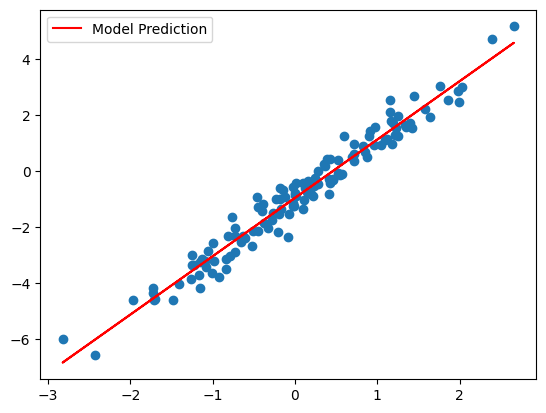

In [29]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend()
plt.show()


### Turn Jax into a stateless language

In [32]:
import jax
import jax.numpy as jnp

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())


1
2
3


In [33]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())


1
1
1


The reason our counter stopped working is the fact that `self.n += 1` is only executed once as a constent during compilation, plus the resulf of the count function doesn't depend on the input paramter, so number zero is cached for n and it just keeps adding 1 with 0.

To fix this, the below example turns `count` into a stateful function.

In [35]:
CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> Tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as 
    # the output and as the counter state for didactic purposes.
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)


1
2
3


in the above example, the state always have the latest information, so add the end, we should treat Jax as a stateless application with functional programming mindset in mind.

In [36]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)


1
2
3


Interestingly enough, the OOP (Object-Oriented Programming) paradigm is less useful in this context because the class helps to maintain state, but it clearly doesn't serve any purpose if you jaxify it. Therefore, this class is merely a way to gather all the methods in one location. We could transform this into a set of independent functions and nothing would change."